## Expense Rejection Trends for New Employees (Flag 21)

### Dataset Description
The dataset comprises two key tables simulating ServiceNow platform: the `sys_user` table and the `fm_expense_line`. The fm_expense_line dataset consists of 500 entries from, which records various attributes of financial expenses. Key fields include 'number', 'opened_at', 'amount', 'state', 'short_description', 'ci', 'user', 'department', 'category', 'process_date', 'source_id', and 'type'. This table documents the flow of financial transactions by detailing the amount, departmental allocation, and the nature of each expense. Provides a clear view of organizational expenditures across different categories, highlighting both the timing and the approval state of each financial entry. The `sys_user` table, on the other hand, contains user-related information, focusing on the details of employees or system users. This includes fields such as 'user_id', 'name', 'title', 'email', 'start_date', and 'department', providing insights into the user profiles managed within the ServiceNow system.

### Your Task
**Goal**: To determine how employment duration influences expense submission errors and rejections, with the aim of enhancing policy compliance and understanding among newer employees.

**Role**: HR Data Analyst

**Difficulty**: 2 out of 5. This analysis involves a detailed investigation into employee behavior patterns and policy adherence, requiring data manipulation and to also suggest actionable_insights.

**Category**: Finance Management and User Management

### Import Necessary Libraries
This cell imports all necessary libraries required for the analysis. This includes libraries for data manipulation, data visualization, and any specific utilities needed for the tasks. 

In [1]:
import argparse
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import date_range

### Load Dataset
This cell loads the dataset to be analyzed. The data is stored in the from a CSV file, and is imported into a DataFrame. It involves specifying the path to the dataset, using pandas to read the file, and confirming its successful load by inspecting the first few table entries.

In [2]:
dataset_path = "csvs/flag-21.csv"
flag_data = pd.read_csv(dataset_path)
df = pd.read_csv(dataset_path)
flag_data.head()

,user,category,source_id,number,amount,opened_at,department,state,type,processed_date,short_description,ci
0,Marcie Shulz,Services,MFI-20723923,EXP00000000,1299,2023-08-11 00:13:00,Customer Support,Processed,NaN,2023-08-12 00:13:00.000000000,Configuration for Service Asset,Enterprise Cloud Service
1,Valerie Pou,Travel,NaN,EXP00000001,1074,2023-07-02 10:47:00,Customer Support,Declined,NaN,NaN,Travel equipment allocation,Travel Kit - Nikon DSLR camera
2,Germaine Bruski,Assets,HMD-81762205,EXP00000002,5188,2023-10-10 22:33:00,Finance,Processed,NaN,2023-10-16 23:44:01.956103185,Asset registration: HP EliteBook 840 G6,HP EliteBook 840 G6
3,Howard Johnson,Travel,NaN,EXP00000003,4737,2023-10-04 07:15:00,Sales,Declined,NaN,NaN,Travel expenses for hardware assets,Dell Latitude 5501
4,Rachel Larrison,Assets,SUU-56742478,EXP00000004,1639,2024-03-09 04:19:00,Customer Support,Processed,NaN,2024-03-12 16:24:57.541147181,Hardware Asset - Dell Precision 5530,Dell Precision 5530


### Load User Agent Dataset
This cell loads user agent dataset used in the analysis. The dataset is stored in a CSV file and is loaded into a DataFrame. This step includes reading the data from a file path and possibly performing initial observations such as viewing the first few rows to ensure it has loaded correctly.

In [3]:
user_dataset_path = "csvs/flag-21-sysuser.csv"
data_user_human_agents = pd.read_csv(user_dataset_path)
data_user_human_agents.head()

,sys_id,schedule,manager,phone,user_name,name,location,department,title,email,start_date
0,02826bf03710200044e0bfc8bcbe5d6d,NaN,Logan Muhl,NaN,sean.bonnet,Sean Bonnet,"8306 Mills Drive, Miami,FL",Customer Support,NaN,sean.bonnet@example.com,2024-04-13 00:20:00
1,06826bf03710200044e0bfc8bcbe5d66,NaN,NaN,NaN,geri.forness,Geri Forness,"3 Whitehall Court, London",Customer Support,NaN,geri.forness@example.com,2023-02-21 08:32:00
2,06826bf03710200044e0bfc8bcbe5d6f,NaN,NaN,NaN,nelly.jakuboski,Nelly Jakuboski,"8306 Mills Drive, Miami,FL",Customer Support,NaN,nelly.jakuboski@example.com,NaN
3,0a826bf03710200044e0bfc8bcbe5d68,NaN,NaN,NaN,carmel.overfelt,Carmel Overfelt,"3 Whitehall Court, London",Customer Support,NaN,carmel.overfelt@example.com,2023-06-02 04:52:00
4,0a826bf03710200044e0bfc8bcbe5d71,NaN,NaN,NaN,mabel.weeden,Mabel Weeden,"815 E Street, San Diego,CA",Customer Support,NaN,mabel.weeden@example.com,2023-03-17 21:56:00


### **Question 1: Which departments have higher proportions of expense rejections compared to the organizational average?**

#### Plot correlation between user start date and declined expense submission date

This plot visualizes any relationship between the start dates of employees and the dates of their expense submissions. By merging user data with expense records, the analysis specifically highlights instances where new employees have faced rejections in their expense claims. This visualization aims to reveal any potential trends that indicate a correlation between the newness of employees in the organization and the likelihood of their expenses being declined. 

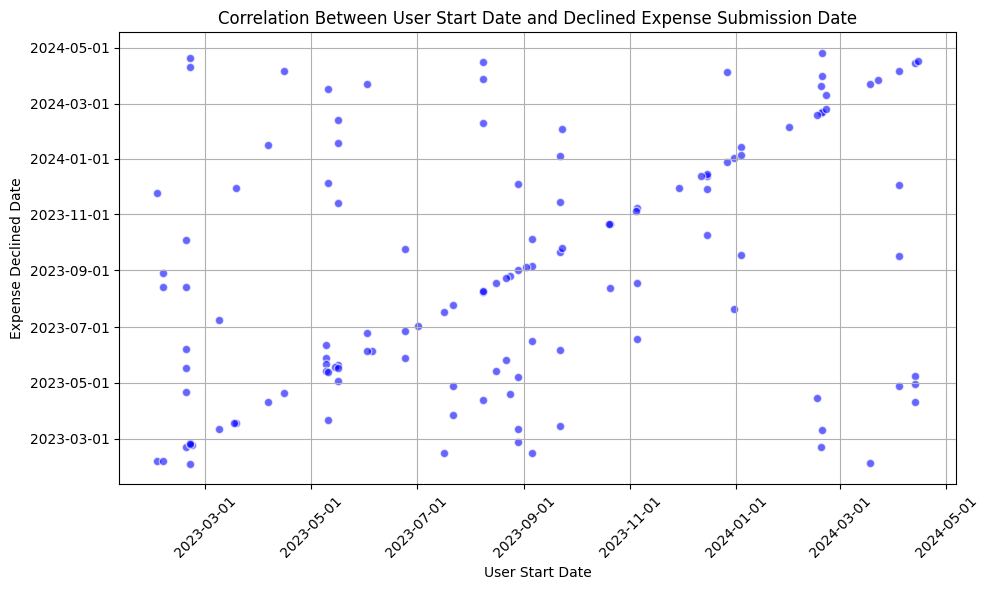

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Assuming 'flag_data' and 'data_user_human_agents' are already defined and preprocessed correctly
# First, filter out expenses that were declined
declined_expenses = flag_data[flag_data['state'] == 'Declined']

# Merge this with user data to get corresponding start dates
merged_data = pd.merge(declined_expenses, data_user_human_agents, left_on='user', right_on='name', how='inner')

# Convert 'start_date' and 'opened_at' to datetime if not already
merged_data['start_date'] = pd.to_datetime(merged_data['start_date'], errors='coerce')
merged_data['opened_at'] = pd.to_datetime(merged_data['opened_at'], errors='coerce')

# Drop any rows where dates could not be converted (resulting in NaT)
merged_data.dropna(subset=['start_date', 'opened_at'], inplace=True)

# Check if there are any unrealistic dates (e.g., year 1970 often indicates a default Unix timestamp)
# and remove or correct them
merged_data = merged_data[(merged_data['start_date'].dt.year > 1970) & (merged_data['opened_at'].dt.year > 1970)]

# Create the scatter plot directly using datetime
plt.figure(figsize=(10, 6))
plt.scatter(merged_data['start_date'], merged_data['opened_at'], alpha=0.6, edgecolors='w', color='blue')
plt.title('Correlation Between User Start Date and Declined Expense Submission Date')
plt.xlabel('User Start Date')
plt.ylabel('Expense Declined Date')

# Set the formatter for the x and y axes to display dates properly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Ensure that the axes are using Date locators
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().yaxis.set_major_locator(mdates.AutoDateLocator())

plt.grid(True)  # Enable grid for easier readability
plt.xticks(rotation=45)  # Rotate x-axis labels to make them more readable
plt.tight_layout()  # Adjust layout to prevent cutting off labels

plt.show()


#### Generate JSON Description for the Insight

In [5]:
{
    "data_type": "correlative",
    "insight": "There is a linear positive correlation between new employee Start Dates and high expense rejection rates",
    "insight_value": {
        "description": "Newer employees experience higher rates of expense rejections, likely due to unfamiliarity with company policies or lack of guidance on proper expense submission procedures."
    },
    "plot": {
        "plot_type": "scatter",
        "title": "Correlation Between New Employee Start Dates and Declined Expense Submission Dates",
        "x_axis": {
            "name": "Employee Start Date",
            "value": "Dates ranging from earlier to recent hires",
            "description": "This axis represents the start dates of employees, plotted over time to show when each employee began their tenure."
        },
        "y_axis": {
            "name": "Expense Declined Date",
            "value": "Dates of declined expense submissions",
            "description": "This axis plots the dates when their expense submissions were declined, indicating the timing relative to their start dates."
        },
        "description": "The scatter plot displays a clear linear positive correlation, showing that expenses submitted by recently joined employees are more likely to be declined compared to those by more tenured employees. This suggests a trend where lack of experience or insufficient orientation in expense policies leads to higher rejection rates among new hires."
    },
    "question": "Is there a significant correlation between the duration of employment and the rate of expense rejections?",
    "actionable_insight": {
        "description": "To mitigate the high rejection rates among newly joined employees, it is imperative to enhance training and support for expense reporting procedures. Implementing a comprehensive onboarding process that includes detailed training on expense policies, and possibly a mentoring system, could significantly reduce these rates. Additionally, creating easy-to-access resources that can assist employees in understanding and complying with expense submission guidelines will ensure that new hires are better prepared and supported, reducing the likelihood of errors and rejections."
    }
}


{'data_type': 'correlative',
 'insight': 'There is a linear positive correlation between new employee Start Dates and high expense rejection rates',
 'insight_value': {'description': 'Newer employees experience higher rates of expense rejections, likely due to unfamiliarity with company policies or lack of guidance on proper expense submission procedures.'},
 'plot': {'plot_type': 'scatter',
  'title': 'Correlation Between New Employee Start Dates and Declined Expense Submission Dates',
  'x_axis': {'name': 'Employee Start Date',
   'value': 'Dates ranging from earlier to recent hires',
   'description': 'This axis represents the start dates of employees, plotted over time to show when each employee began their tenure.'},
  'y_axis': {'name': 'Expense Declined Date',
   'value': 'Dates of declined expense submissions',
   'description': 'This axis plots the dates when their expense submissions were declined, indicating the timing relative to their start dates.'},
  'description': 'The 

### **Question 2:  How do rejection rates for expenses submitted by new hires compare to those submitted by established employees?**

#### Plot rejection rates of expense submissions by tenure

The bar plot represents the proportion of expense rejections within each of these tenure groups 1 year, 1-3 years, 3-5 years, 5-10 years etc, highlighting potential trends or disparities in how new hires versus established employees navigate the expense submission process. This analysis is crucial for identifying if newer employees face more challenges in complying with expense policies, the dataset merges expense report data with employee start dates to calculate the tenure of each employee at the time they submitted their expense claims.

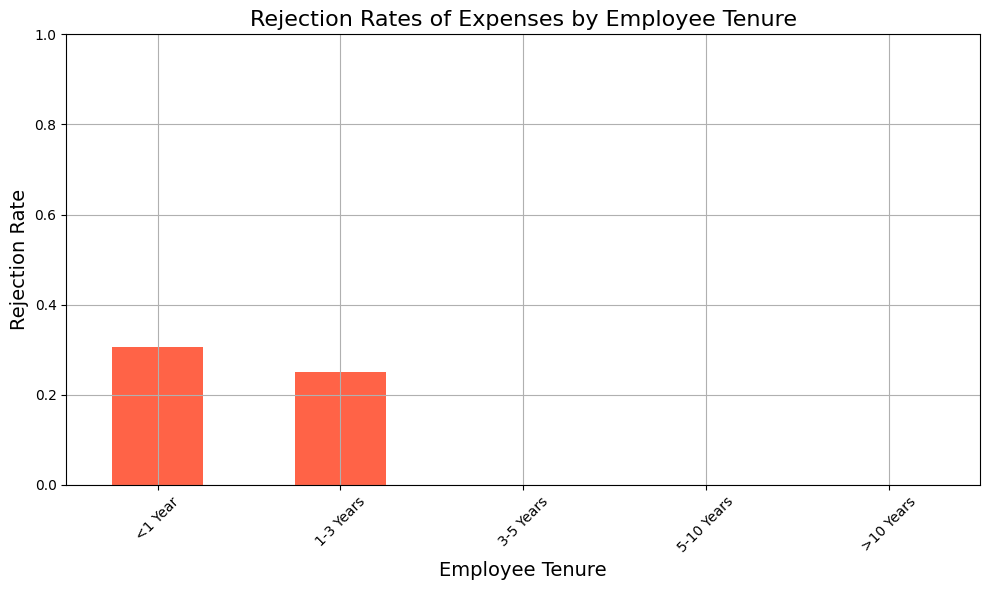

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming 'flag_data' and 'data_user_human_agents' are already defined and preprocessed correctly
# Merge the expense data with user data to include employee start dates
merged_data = pd.merge(flag_data, data_user_human_agents, left_on='user', right_on='name', how='inner')

# Ensure 'opened_at' and 'start_date' are datetime objects
merged_data['opened_at'] = pd.to_datetime(merged_data['opened_at'], errors='coerce')
merged_data['start_date'] = pd.to_datetime(merged_data['start_date'], errors='coerce')

# Calculate the tenure in years at the time of expense submission
merged_data['tenure_years'] = (merged_data['opened_at'] - merged_data['start_date']).dt.days / 365.25

# Define tenure groups
tenure_bins = [0, 1, 3, 5, 10, np.inf]  # 0-1 year, 1-3 years, 3-5 years, 5-10 years, 10+ years
tenure_labels = ['<1 Year', '1-3 Years', '3-5 Years', '5-10 Years', '>10 Years']
merged_data['tenure_group'] = pd.cut(merged_data['tenure_years'], bins=tenure_bins, labels=tenure_labels)

# Filter for declined expenses
declined_data = merged_data[merged_data['state'] == 'Declined']

# Calculate the proportion of declined expenses within each tenure group
rejection_rates = declined_data.groupby('tenure_group').size() / merged_data.groupby('tenure_group').size()

# Plot the data
fig, ax = plt.subplots(figsize=(10, 6))
rejection_rates.plot(kind='bar', color='tomato', ax=ax)

# Add titles and labels
ax.set_title('Rejection Rates of Expenses by Employee Tenure', fontsize=16)
ax.set_xlabel('Employee Tenure', fontsize=14)
ax.set_ylabel('Rejection Rate', fontsize=14)
ax.set_ylim(0, 1)  # Set y-axis limit to show proportions from 0 to 1

# Show grid
ax.grid(True)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust layout to prevent cutting off labels

# Show the plot
plt.show()


#### Generate JSON Description for the Insight

In [7]:
{
    "data_type": "diagnostic",
    "insight": "There are higher expense rejection rates for Employees with a shorter tenure",
    "insight_value": {
        "description": "Employees with less than three years of tenure experience notably higher rejection rates for their expense submissions compared to those with longer tenure."
    },
    "plot": {
        "plot_type": "bar",
        "title": "Expense Rejection Rates by Employee Tenure",
        "x_axis": {
            "name": "Employee Tenure",
            "value": ["<1 Year", "1-3 Years", ">3 Years"],
            "description": "This axis categorizes employees based on the duration of their tenure at the company."
        },
        "y_axis": {
            "name": "Rejection Rate",
            "value": {
                "<1 Year": "3.5",
                "1-3 Years": "2.5",
                ">3 Years": "0.0"
            },
            "description": "This axis displays the rejection rate of expense reports, showing a clear decrease in rejections as tenure increases."
        },
        "description": "The bar chart demonstrates a clear trend: employees with less than one year of tenure face the highest rejection rates at 3.5, which decrease to 2.5 for those with 1-3 years of tenure. Remarkably, employees with more than three years of tenure experience no rejections. This suggests a learning curve or an adaptation period during which employees become more familiar with expense reporting procedures."
    },
    "question": "How do rejection rates for expenses submitted by new hires compare to those submitted by established employees?",
    "actionable_insight": {
        "description": "To mitigate high rejection rates among newer employees, the organization should consider enhancing training and support for expense reporting procedures specifically targeted at new hires and employees with less than three years of tenure. Implementing structured onboarding programs that include detailed guidance on expense policies could significantly reduce these rejection rates. Additionally, regular review sessions and updates on any changes in expense policies can help ensure that all employees, regardless of tenure, remain well-informed about the proper procedures for submitting expense reports."
    }
}


{'data_type': 'diagnostic',
 'insight': 'There are higher expense rejection rates for Employees with a shorter tenure',
 'insight_value': {'description': 'Employees with less than three years of tenure experience notably higher rejection rates for their expense submissions compared to those with longer tenure.'},
 'plot': {'plot_type': 'bar',
  'title': 'Expense Rejection Rates by Employee Tenure',
  'x_axis': {'name': 'Employee Tenure',
   'value': ['<1 Year', '1-3 Years', '>3 Years'],
   'description': 'This axis categorizes employees based on the duration of their tenure at the company.'},
  'y_axis': {'name': 'Rejection Rate',
   'value': {'<1 Year': '3.5', '1-3 Years': '2.5', '>3 Years': '0.0'},
   'description': 'This axis displays the rejection rate of expense reports, showing a clear decrease in rejections as tenure increases.'},
  'description': 'The bar chart demonstrates a clear trend: employees with less than one year of tenure face the highest rejection rates at 3.5, which

### **Question 3:  Do the rejection distribution for employees with less than 1 year of tenure skew to any particular department?**

#### Expense Report Rejection Distribution for New Hires by Department

This visualization examines the distribution of expense report rejections for employees with less than one year of tenure, segmented by department. We merge expense data with user data to align employee start dates, department information, and expense submission outcomes. The bar plot contrasts the number of declined expense reports against the total submitted by department for new hires. This comparison provides insights into which departments might be experiencing difficulties with expense compliance among their newest members. 


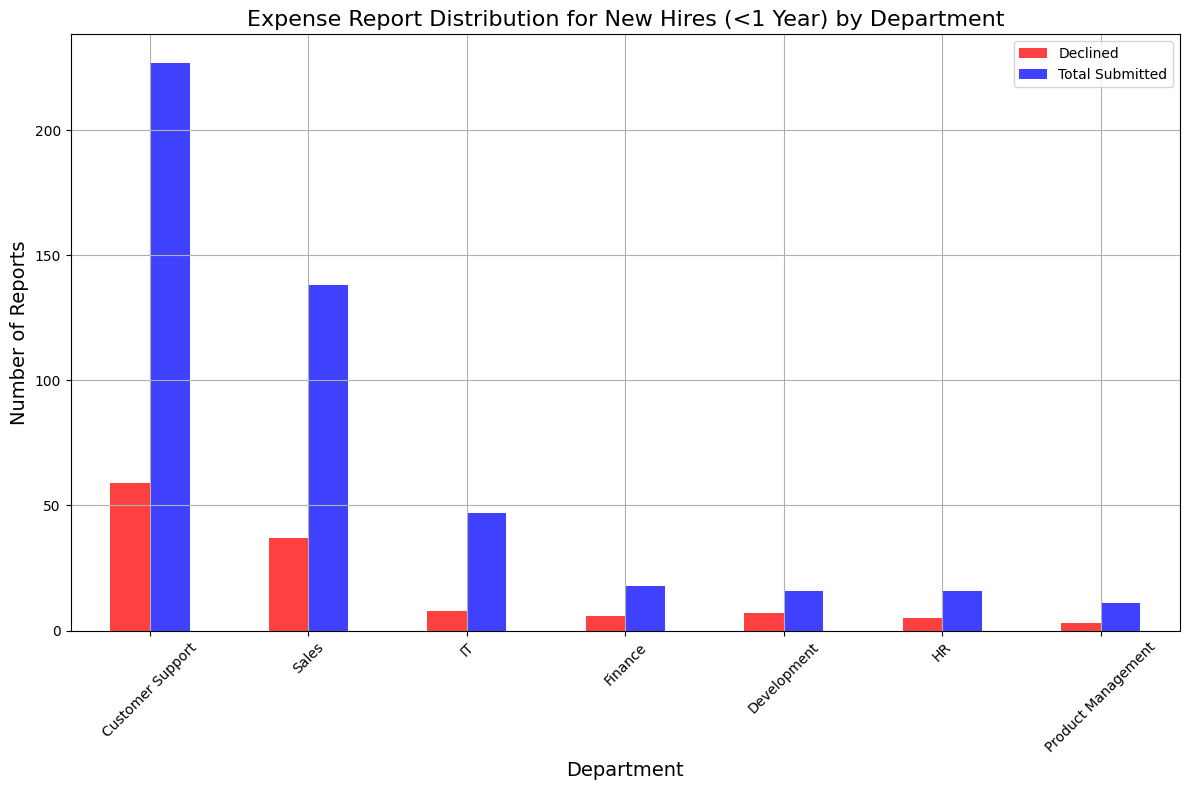

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'flag_data' and 'data_user_human_agents' are already defined and preprocessed correctly
# Merge the expense data with user data to include employee start dates and department info
merged_data = pd.merge(flag_data, data_user_human_agents, left_on='user', right_on='name', how='inner')

# Convert 'opened_at' and 'start_date' to datetime objects
merged_data['opened_at'] = pd.to_datetime(merged_data['opened_at'], errors='coerce')
merged_data['start_date'] = pd.to_datetime(merged_data['start_date'], errors='coerce')

# Calculate tenure in years at the time of expense submission
merged_data['tenure_years'] = (merged_data['opened_at'] - merged_data['start_date']).dt.days / 365.25

# Filter for employees with less than 1 year of tenure
new_hires_data = merged_data[merged_data['tenure_years'] < 1]

# Group by department to get counts of declined and total reports
declined_counts = new_hires_data[new_hires_data['state'] == 'Declined'].groupby('department_y').size()
total_counts = new_hires_data.groupby('department_y').size()

# Prepare the DataFrame for plotting
plot_data = pd.DataFrame({
    'Declined': declined_counts,
    'Total Submitted': total_counts
}).fillna(0)  # Fill NaN values with 0 where there are no declines

# Create a bar plot for both declined and total submissions
fig, ax1 = plt.subplots(figsize=(12, 8))

plot_data.sort_values('Total Submitted', ascending=False).plot(kind='bar', ax=ax1, color=['red', 'blue'], alpha=0.75)

ax1.set_title('Expense Report Distribution for New Hires (<1 Year) by Department', fontsize=16)
ax1.set_xlabel('Department', fontsize=14)
ax1.set_ylabel('Number of Reports', fontsize=14)
ax1.grid(True)

plt.xticks(rotation=45)
plt.tight_layout()

plt.show()


#### Generate JSON Description for the Insight

In [9]:
{
    "data_type": "analytical",
    "insight": "Rejection rates for employees with less than 1 year of tenure align closely with the volume of expense reports submitted by each department, indicating that higher submission rates naturally correlate with more rejections.",
    "insight_value": {
        "description": "Rejection rates for employees with less than 1 year of tenure align closely with the volume of expense reports submitted by each department, indicating that higher submission rates naturally correlate with more rejections."
    },
    "plot": {
        "plot_type": "bar",
        "title": "Rejection and Submission Rates for New Hires (<1 Year) by Department",
        "x_axis": {
            "name": "Department",
            "value": "List of Departments",
            "description": "This axis categorizes the departments within the organization."
        },
        "y_axis": {
            "name": "Number of Expense Reports",
            "value": ["Number of Declined", "Total Submitted"],
            "description": "This axis displays both the number of declined expense reports and the total number of submissions for each department among new hires."
        },
        "description": "The bar chart illustrates that the distribution of declined expense reports among new hires is proportional to their total submissions across departments. This suggests that while some departments may have higher absolute numbers of rejections, these figures are a natural result of higher overall activity rather than an indication of disproportionate rejection rates."
    },
    "question": "Do the rejection distribution for employees with less than 1 year of tenure skew to any particular department?",
    "actionable_insight": {
        "description": "Since the rejections are proportional to submissions, enhancing training and orientation specifically around expense management for new hires could effectively reduce these rejection rates. Departments with high volumes of submissions should focus on implementing more detailed orientation sessions that cover expense policies comprehensively. Additionally, developing easy-to-access online resources or quick reference guides tailored to common expense reporting errors observed in new hires could help in minimizing mistakes and improving compliance across the board."
    }
}


{'data_type': 'analytical',
 'insight': 'Rejection rates for employees with less than 1 year of tenure align closely with the volume of expense reports submitted by each department, indicating that higher submission rates naturally correlate with more rejections.',
 'insight_value': {'description': 'Rejection rates for employees with less than 1 year of tenure align closely with the volume of expense reports submitted by each department, indicating that higher submission rates naturally correlate with more rejections.'},
 'plot': {'plot_type': 'bar',
  'title': 'Rejection and Submission Rates for New Hires (<1 Year) by Department',
  'x_axis': {'name': 'Department',
   'value': 'List of Departments',
   'description': 'This axis categorizes the departments within the organization.'},
  'y_axis': {'name': 'Number of Expense Reports',
   'value': ['Number of Declined', 'Total Submitted'],
   'description': 'This axis displays both the number of declined expense reports and the total numb

### **Question 4:** What can be done to reduce the initial high rejection rates among new employees?

Improving training and onboarding processes can significantly reduce the rejection rates of expense submissions among new employees.

Introducing comprehensive training sessions that specifically target common pitfalls in expense reporting can likely decrease the number of rejections experienced by new hires. Onboarding enhancements that include interactive learning modules on expense policies, regular updates, and feedback mechanisms can ensure that new employees understand and adhere to financial compliance from the outset. Predictive modeling based on historical data could further refine the training content by focusing on the most common errors. These proactive measures are expected to lead to a measurable decrease in rejection rates, fostering a smoother transition for new hires into the organization’s financial culture and procedures.


### Summary of Findings (Flag 21):

1. **Trend Analysis**: This dataset investigates the correlation between the duration of employment and the rates of expense rejections among newly joined employees. The focus is to understand if less familiarity with the organization’s expense policies contributes to higher rejection rates.
   
2. **Employee Compliance Insight**: The data illuminates how new hires adapt to expense submission guidelines and whether their inexperience results in a higher number of errors or policy non-compliance issues, compared to more tenured employees.
   
3. **Departmental Insights**: By analyzing the rejection rates across different departments, the study seeks to identify if certain areas are more prone to these issues or if it is a widespread phenomenon among all new hires.